# Прикладной анализ временных рядов

Выполнил: студент AI Talent Hub ITMO \
ФИО: Щетинников К. \
Группа: M4254

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet

from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

sns.set_theme()

In [171]:
class DataProcesser():
    def load_data(self, sales_path, prices_path, calendar_path):
        self.sales = pd.read_csv(sales_path)
        self.prices = pd.read_csv(prices_path)
        self.calendar = pd.read_csv(calendar_path)
        print('Data loaded')
    
    def get_holidays(self):
        calendar_data = self.calendar.copy()
        calendar_data['date'] = pd.to_datetime(calendar_data['date'])
        calendar_data['event'] = calendar_data['event_name_1'].combine_first(calendar_data['event_name_2'])
        holidays_data = calendar_data.dropna(subset=['event'])
        holidays = holidays_data[['date', 'event']]
        return holidays.rename(columns={'date': 'ds', 'event': 'holiday'})
    
    def get_processed_data(self, art):
        if not art:
            print('Specify item')
        self.data = self.calendar.merge(self.sales, on='date_id') \
                                 .merge(self.prices, on=['item_id', 'store_id', 'wm_yr_wk'], 
                                        how='left').sort_values(by='date')
        self.data['is_weekend'] = self.data['wday'] \
                                      .apply(lambda x: 1 if x < 3 else 0)
        self.data = pd.get_dummies(self.data,
                                   columns=['event_type_1'],
                                   prefix='type',
                                   dtype=int)
        self.data.drop(axis=1,
                       columns=['wm_yr_wk',
                                'year',
                                'event_name_2',
                                'event_type_2',
                                'event_name_1',
                                'weekday',
                                'CASHBACK_STORE_1', 
                                'CASHBACK_STORE_3'],
                        inplace=True)
        
        self.data['date'] = pd.to_datetime(self.data['date'])
        self.data = self.data.rename(columns={'date': 'ds', 'cnt': 'y'})
        self.data = self.data[self.data.item_id==art]
        return self.data
    
    def get_split_data(self, data, test_size=90):
        train = data.iloc[:-test_size].copy()
        mean_sell_price = train['sell_price'].mean()
        train.fillna({'sell_price': mean_sell_price}, inplace=True)
        test = data.iloc[-test_size:].copy()
        test.fillna({'sell_price': mean_sell_price}, inplace=True)
        return train, test

In [172]:
class SalesForecaster():
    def fit(self, data, holidays=None):
        self.data = data
        if holidays is None:
            self.model = Prophet()
        else:
            self.model = Prophet(holidays=holidays)
        self.model.add_regressor('CASHBACK_STORE_2')
        self.model.add_regressor('type_Cultural')
        self.model.add_regressor('type_Sporting')
        self.model.add_regressor('type_Religious')
        self.model.add_regressor('type_National')
        self.model.add_regressor('is_weekend')
        self.model.add_regressor('sell_price')
        self.model.fit(data)
        
    def predict(self, num_days, features):
        future = self.model.make_future_dataframe(periods=num_days)[-num_days:].reset_index(drop=True)
        features = features.drop(columns=['ds']).reset_index(drop=True)
        date_features = pd.concat([future, features], axis=1)
        forecast = self.model.predict(date_features)
        return forecast
    
    def get_metrics_report(self, y_true, y_pred):
        y_true_mean = y_true.mean().values * np.ones(shape=(len(y_true),))

        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        mae = mean_absolute_error(y_true, y_pred)
        mae_zero = mean_absolute_error(y_true_mean, y_pred)
        
        resport = pd.DataFrame([mse, r2, mae, mae_zero],
                                index=['mse', 'r2', 'mae', 'mae_zero'])

        return resport

## Данные

In [173]:
# загрузка данных 
processer = DataProcesser()
processer.load_data(sales_path='../data/shop_sales.csv',
                    prices_path='../data/shop_sales_prices.csv',
                    calendar_path='../data/shop_sales_dates.csv')

Data loaded


In [174]:
# тренировочные и тестовые данных
holidays = processer.get_holidays()
data = processer.get_processed_data(art='STORE_2_085')
data_train, data_test = processer.get_split_data(data, test_size=90)

In [175]:
data.head()

,ds,wday,month,date_id,CASHBACK_STORE_2,item_id,store_id,y,sell_price,is_weekend,type_Cultural,type_National,type_Religious,type_Sporting
0,2011-01-29,1,1,1,0,STORE_2_085,STORE_2,3,1.0,1,0,0,0,0
45,2011-01-30,2,1,2,0,STORE_2_085,STORE_2,8,1.0,1,0,0,0,0
90,2011-01-31,3,1,3,0,STORE_2_085,STORE_2,0,1.0,0,0,0,0,0
135,2011-02-01,4,2,4,1,STORE_2_085,STORE_2,3,1.0,0,0,0,0,0
180,2011-02-02,5,2,5,1,STORE_2_085,STORE_2,0,1.0,0,0,0,0,0


In [176]:
data_train.head()

,ds,wday,month,date_id,CASHBACK_STORE_2,item_id,store_id,y,sell_price,is_weekend,type_Cultural,type_National,type_Religious,type_Sporting
0,2011-01-29,1,1,1,0,STORE_2_085,STORE_2,3,1.0,1,0,0,0,0
45,2011-01-30,2,1,2,0,STORE_2_085,STORE_2,8,1.0,1,0,0,0,0
90,2011-01-31,3,1,3,0,STORE_2_085,STORE_2,0,1.0,0,0,0,0,0
135,2011-02-01,4,2,4,1,STORE_2_085,STORE_2,3,1.0,0,0,0,0,0
180,2011-02-02,5,2,5,1,STORE_2_085,STORE_2,0,1.0,0,0,0,0,0


## Прогноз

In [177]:
forecaster = SalesForecaster()
forecaster.fit(data_train, holidays=holidays)

13:05:32 - cmdstanpy - INFO - Chain [1] start processing
13:05:32 - cmdstanpy - INFO - Chain [1] done processing


In [178]:
data_pred = forecaster.predict(90, data_test)
data_pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,CASHBACK_STORE_2,CASHBACK_STORE_2_lower,CASHBACK_STORE_2_upper,Chanukah End,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-10-24,8.893186,6.080126,14.843695,8.893186,8.893186,0.0,0.0,0.0,0.0,...,0.542623,0.542623,0.542623,-0.129906,-0.129906,-0.129906,0.0,0.0,0.0,10.594866
1,2015-10-25,8.912885,5.522841,14.826939,8.912885,8.912885,0.0,0.0,0.0,0.0,...,-0.001075,-0.001075,-0.001075,-0.116342,-0.116342,-0.116342,0.0,0.0,0.0,10.084430
2,2015-10-26,8.932583,3.917542,13.379512,8.932583,8.932583,0.0,0.0,0.0,0.0,...,-0.558190,-0.558190,-0.558190,-0.112033,-0.112033,-0.112033,0.0,0.0,0.0,8.591020
3,2015-10-27,8.952281,4.174144,13.475608,8.952281,8.952281,0.0,0.0,0.0,0.0,...,-0.102549,-0.102549,-0.102549,-0.119215,-0.119215,-0.119215,0.0,0.0,0.0,9.059178
4,2015-10-28,8.971980,3.831231,13.473193,8.971980,8.971980,0.0,0.0,0.0,0.0,...,-0.182988,-0.182988,-0.182988,-0.139844,-0.139844,-0.139844,0.0,0.0,0.0,8.977808


In [179]:
forecaster.get_metrics_report(data_test[['y']], data_pred[['yhat']])

,0
mse,30.221017
r2,-0.090530
mae,4.367978
mae_zero,1.433633


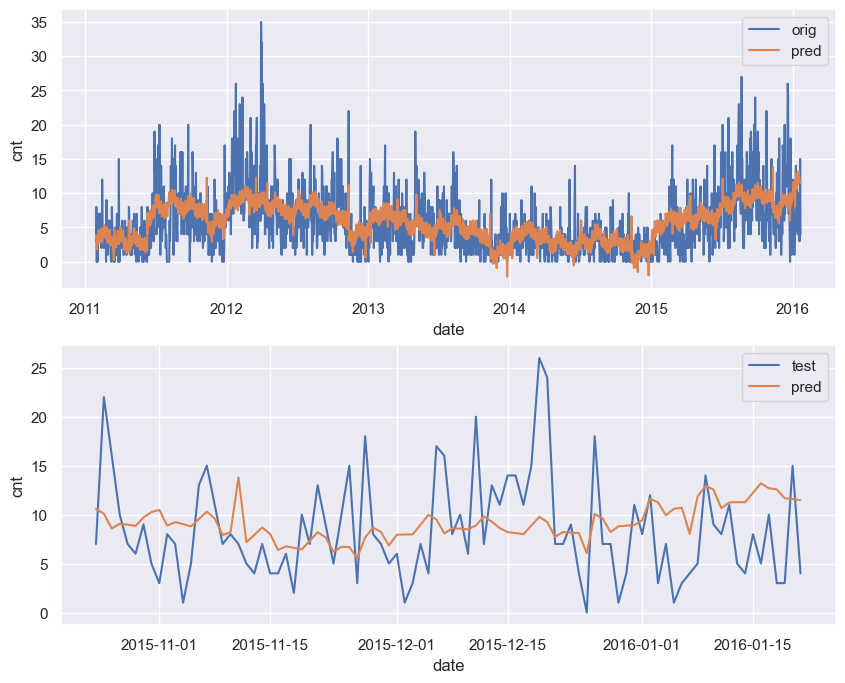

In [180]:
data_pred = forecaster.model.predict(data)
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(data.set_index('ds')['y'], label='orig')
plt.plot(data_pred.set_index('ds')['yhat'], label='pred')
plt.xlabel('date')
plt.ylabel('cnt')
plt.legend()

data_pred = forecaster.model.predict(data_test)
plt.subplot(2, 1, 2)
plt.plot(data_test.set_index('ds')['y'], label='test')
plt.plot(data_pred.set_index('ds')['yhat'], label='pred')
plt.xlabel('date')
plt.ylabel('cnt')
plt.legend()